# Step 2. Event Study Model

By Sung Choi 

May 19, 2020

# My event

Source: https://www.nytimes.com/article/coronavirus-timeline.html

- First case of COVID-19 in the world: 2019-12-31
- First case of COVID-19 in the US: 2020-01-21
- Universities shutdown around 2020-03-16?

# Data

In [1]:
use "save/stocks_health_care_sector.dta", clear

# Variables

In [2]:
// change from date-time to date (stata calls it clock to date)
replace Date = dofc(Date)
format %td Date


(344 real changes made)



firm data is a long data, firm stock prices are stacked up and down.

stock ticker is a string. create a numeric id.

In [3]:
// egen co_id = group(co_name)
egen ticker_id = group(ticker)
order ticker_id
sort ticker_id Date

by company id, create a variable that shows the nth position (nth day) of the row. this variable shows the relative time (nth day), which is different from absolute time (year month date)

In [4]:
// bysort co_id: gen days_co =_n
bysort ticker_id: gen day_n =_n

xtset using numeric company id, and relative days

In [5]:
// xtset co_id days_co
xtset ticker_id day_n

       panel variable:  ticker_id (strongly balanced)
        time variable:  day_n, 1 to 344
                delta:  1 unit


create variable for returns (log returns)

In [6]:
gen frm_ret = ln(Adj_Close/l.Adj_Close)
gen mkt_ret = ln(MARKET_Adj_Close/l.MARKET_Adj_Close)


(1 missing value generated)

(1 missing value generated)


## Event Specification

- event_id: Event ID
- ticker: ticker
- event_date: 1 if date == specified event date
- event_type: Event type, grouping variable (2)
- event_start: Start Event Window (3)
- event_end: End Event Window (3)
- est_end: End of Estimation Window (3)
- est_length: Estimation Window Length

Stata code adopted from:
- https://www.eventstudytools.com/stata
- https://www.eventstudytools.com/barc/upload 
- https://www.eventstudytools.com/downloads/sample_data_aarc.zip

In [ ]:
// Filter by tickers and event_date
local tickers = "XLV"
scalar my_event_date = "16mar2020"

// Then set variables to
scalar my_event_type = "covid"
scalar my_event_start = -20
scalar my_event_end = 20
scalar my_est_end = -30
scalar my_est_length = 100

gen event_type  = ""
gen event_start = .
gen event_end   = .
gen est_end     = .
gen est_length  = .


foreach tick of local tickers{
    replace event_type  = my_event_type if ticker == "`tick'" & Date == date(my_event_date, "DMY")
    replace event_start = my_event_start if ticker == "`tick'" & Date == date(my_event_date, "DMY")
    replace event_end   = my_event_end if ticker == "`tick'" & Date == date(my_event_date, "DMY")
    replace est_end     = my_est_end if ticker == "`tick'" & Date == date(my_event_date, "DMY")
    replace est_length  = my_est_length if ticker == "`tick'" & Date == date(my_event_date, "DMY")
}


### Setting Estimation Window, Event Window

`event_date` is set to `days_co` (relative time of event ) if event_id is not missing (if the row is on a date that had an event)

In [8]:
bysort ticker_id: gen event_day_n = day_n if  event_type != ""
bysort ticker_id: egen event_day_n_grp = max(event_day_n) 


(343 missing values generated)



`est_diff` centers (zero) the relative time to boundary point between estimation-windows and event-window (this is t0 in figure in clean1_estudy.ipynb). From zero, it counts down to the length of the estimation window (how many days from zero is included in estimation window) plus 1 (because of zero-based counting)

`est_flag` is a dummy set to 1 if row is in the estimation window. 

`event_diff`centers (zero) the relative time to event-time
`event_flag` is a dummy set to 1 if row is in event window

In [ ]:
// Filter by tickers and event_date

gen est_diff = .
gen est_flag = .

replace est_diff = day_n - (event_day_n_grp + my_est_end + 1)
replace est_flag = 1 if est_diff >= (-my_est_length)
replace est_flag = . if est_diff >= 0

gen event_diff = .
gen event_flag = .

replace event_diff = day_n - event_day_n_grp
replace event_flag = 1 if event_diff >= my_event_start & event_diff <= my_event_end


# Estimating Normal Performance

In [10]:
// Filter by tickers and event_date

// save rmse_ to use later in significance testing

gen predicted_return = .
foreach tick of local tickers{
  di "`tick'"
    
  reg frm_ret mkt_ret if ticker == "`tick'" & est_flag == 1
  scalar rmse_`tick' = `e(rmse)'
  predict p if  ticker == "`tick'" & event_flag == 1
  replace predicted_return = p if  ticker == "`tick'" & event_flag == 1
  drop p

  }



(344 missing values generated)

XLV

      Source |       SS           df       MS      Number of obs   =       100
-------------+----------------------------------   F(1, 98)        =    130.02
       Model |  .002793714         1  .002793714   Prob > F        =    0.0000
    Residual |  .002105772        98  .000021487   R-squared       =    0.5702
-------------+----------------------------------   Adj R-squared   =    0.5658
       Total |  .004899486        99   .00004949   Root MSE        =    .00464

------------------------------------------------------------------------------
     frm_ret |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
     mkt_ret |   .8743925   .0766846    11.40   0.000     .7222144    1.026571
       _cons |   .0003703   .0004676     0.79   0.430    -.0005575    .0012982
------------------------------------------------------------------------------
(option xb as

# Abnormal and Cumulative Abnormal Returns

Technical details from: https://dss.princeton.edu/online_help/stats_packages/stata/eventstudy.html

In [ ]:
// Filter by tickers and event_date


gen abnormal_return = .
foreach tick of local tickers{
  replace abnormal_return = frm_ret - predicted_return if ticker == "`tick'"  & event_flag == 1
  }

bysort ticker_id: egen cumulative_abnormal_return = total(abnormal_return) if event_flag == 1

gen cumulative_abnormal_return_day = abnormal_return if event_diff == (my_event_start)
bysort ticker_id: replace cumulative_abnormal_return_day = abnormal_return + cumulative_abnormal_return_day[_n-1] if event_diff >= (my_event_start +1)

# Testing for Significance

Technical details are adopted from:
- https://www.eventstudytools.com/significance-tests

- https://www.univaasa.fi/fi/research/publications/publicationseries/old/luoma_pynnonen_fullpaper.pdf and http://www.mysmu.edu/faculty/christophert/QF604/QF604_W2.pdf

- http://eventstudytools.com/downloads/bARC_Stata.zip

In [ ]:
// Filter by tickers and event_date


gen t_AR = .
gen t_CAR = .
foreach tick of local tickers{
	  replace t_AR = abnormal_return/rmse_`tick' if ticker == "`tick'"  & event_flag == 1
      replace t_CAR = cumulative_abnormal_return/ ( sqrt(my_event_end-my_event_start)*rmse_`tick') if ticker == "`tick'"  & event_flag == 1
	  }

### Summarize the significane tests

Roughly, test statistic is significant if greater than |1.96|.

In [13]:
// list test values
list ticker t_AR t_CAR if event_diff == 0


// bysort ticker: sum  t_AR t_CAR


     +------------------------------+
     | ticker       t_AR      t_CAR |
     |------------------------------|
303. |    XLV   1.602909   2.436493 |
     +------------------------------+


In [14]:
save "save/stocks_health_care_sector_results.dta", replace

file save/stocks_health_care_sector_results.dta saved


# Visualizing The Event Study Model Results

### SP500 price (_GSPC_Adj_Close is SP 500 index)

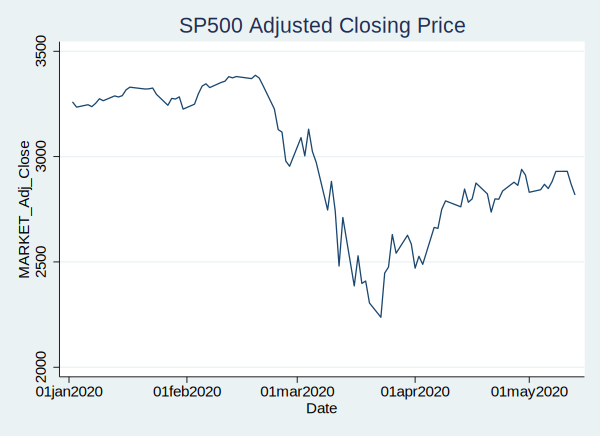

In [15]:
graph twoway line MARKET_Adj_Close Date if ticker == "XLV" &  Date >= date("2020/01/01", "YMD"), ///
title("SP500 Adjusted Closing Price")

### XLV SPDR Healthcare Sector


       panel variable:  ticker_id (strongly balanced)
        time variable:  event_diff, -302 to 41
                delta:  1 unit


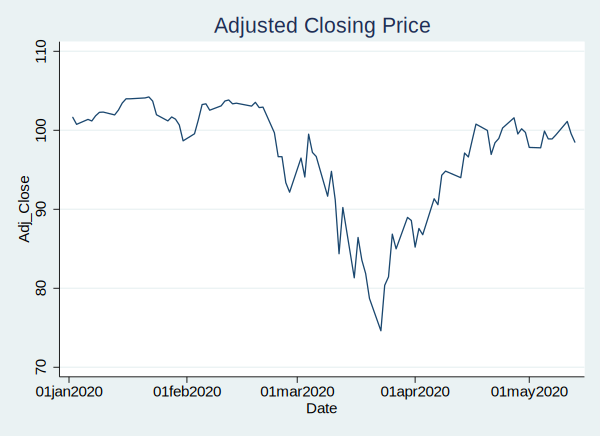

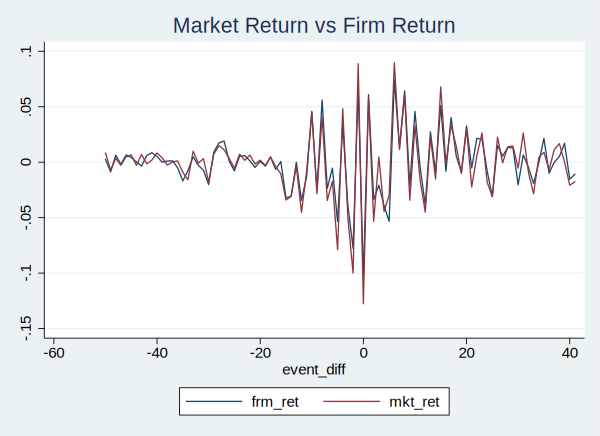

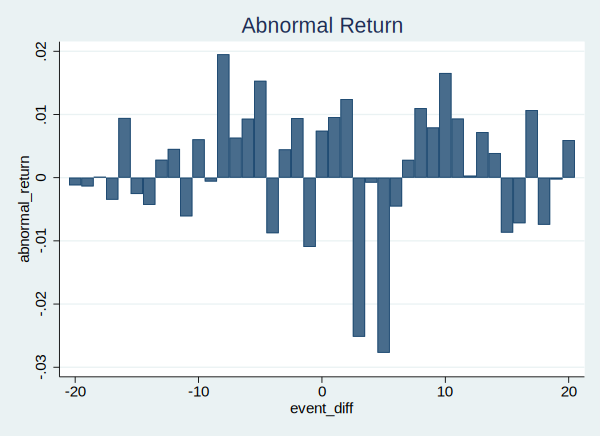

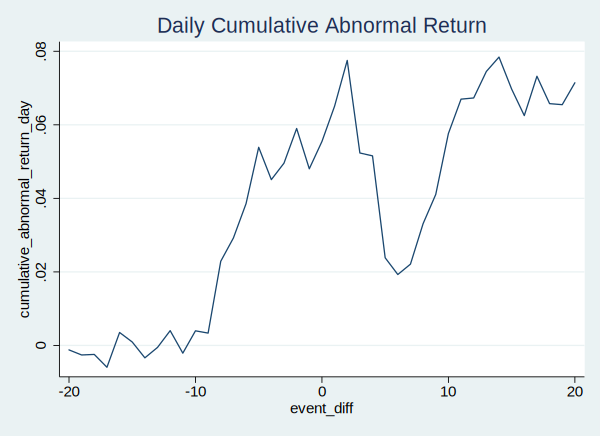

In [16]:
xtset ticker_id event_diff
scalar tick = "XLV"

// Price
graph twoway line Adj_Close Date if ticker == tick & Date >= date("2020/01/01", "YMD"), ///
title("Adjusted Closing Price")

// Market Return vs Firm Return
graph twoway tsline frm_ret mkt_ret if ticker == tick & Date >= date("2020/01/01", "YMD"), ///
title("Market Return vs Firm Return")

// Abnormal Returns
graph twoway bar abnormal_return event_diff if ticker == tick & event_flag == 1, ///
title("Abnormal Return")

// Daily Cumulative Abnormal Returns
graph twoway line cumulative_abnormal_return_day event_diff if ticker == tick & event_flag == 1, ///
title("Daily Cumulative Abnormal Return")